# LT8306
## 1. Select the Transformer Turns Ratio

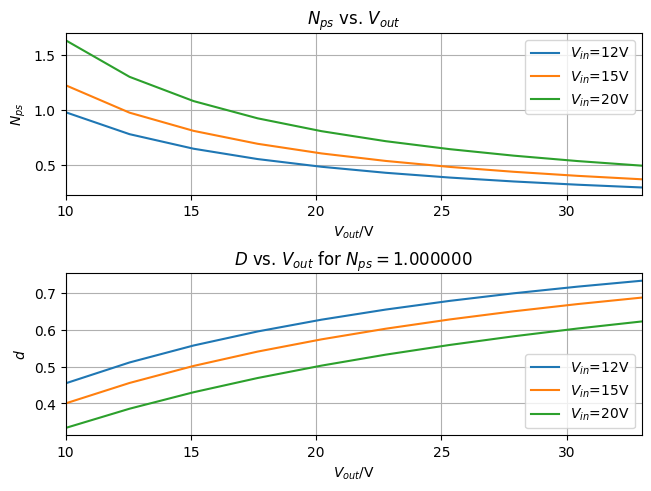

In [126]:
import numpy as np
import matplotlib.pyplot as plt

v_in = np.array([12, 15, 20]) # input voltage between 15V to 20V
v_out = np.linspace(10,33,10)
d_max = 0.45 # duty cycle, typically between 0.45 to 0.65
v_f = 0; # forward voltage (diode) --> set to zero, since LT8309 shall be used

n_ps = np.zeros((len(v_in), len(v_out)))
d = np.zeros((len(v_in), len(v_out)))

# calculate n_ps for different v_in and v_out
for i in range(len(v_in)):
    for j in range(len(v_out)):
        n_ps[i,j] = d_max * v_in[i] / ((1 - d_max) * (v_out[j] + v_f)) # primary to secondary winding ratio

# select n_ps = 1 for design
n_ps_design = 1

# calucate duty cycle for fixed n_ps value
for i in range(len(v_in)):
    for j in range(len(v_out)):
        d[i,j] = ((v_out[j] + v_f)*n_ps_design)/(v_in[i] + (v_out[j] + v_f) * n_ps_design)
      
fig, ax = plt.subplots(2, 1, constrained_layout=True) # create figure

for i in range(len(v_in)):
    ax[0].plot(v_out, n_ps[i, :])
    ax[1].plot(v_out, d[i, :])

# plots
ax[0].set_title('$N_{ps}$ vs. $V_{out}$')
ax[0].legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
ax[0].set_xlabel('$V_{out}$/V')
ax[0].set_ylabel('$N_{ps}$')
ax[0].set_xlim(10,33)
ax[0].grid(True)

ax[1].set_title('$D$ vs. $V_{out}$ for $N_{ps} = %f$' % n_ps_design)
ax[1].legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
ax[1].set_xlabel('$V_{out}$/V')
ax[1].set_ylabel('$d$')
ax[1].set_xlim(10,33)
ax[1].grid(True)

## 2. Calculate $R_{sense}$ Resistor

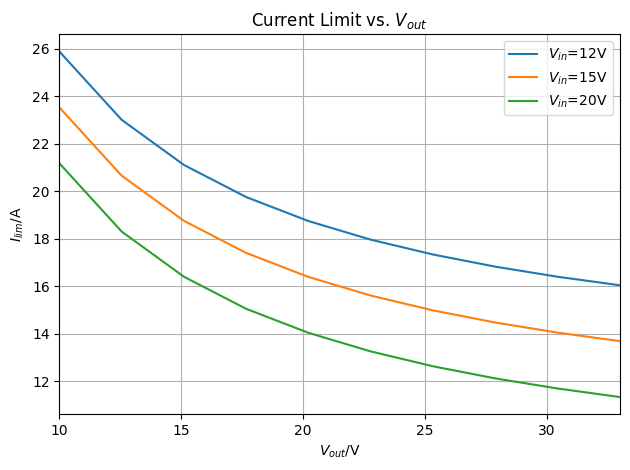

0.002923076923076923


In [127]:
pwr_max = 60 # maximum output power
eta = 0.85 # efficiency

i_lim = np.zeros((len(v_in), len(v_out)))

for i in range(len(v_in)):
    for j in range(len(v_out)):
        i_lim[i,j] = (2 * pwr_max / v_out[j]) / (eta * (1 - d[i,j]) * n_ps_design)

    plt.plot(v_out, i_lim[i,:])

plt.xlabel('$V_{out}$/V')
plt.ylabel('$I_{lim}$/A')
plt.title('Current Limit vs. $V_{out}$')
plt.legend(['$V_{in}$=12V', '$V_{in}$=15V', '$V_{in}$=20V'])
plt.grid(True)
plt.xlim(10,33)
plt.tight_layout()
plt.show()

i_lim_design = 26 / 0.8
r_sense = 95e-3 / i_lim_design

print(r_sense)

## 3. Calculate min. pri. Inductance

In [128]:
v_in_max = 20; # maximum input voltage
v_out_max = 33; # output voltage
v_f = 0.0; # forward voltage (diode) --> set to zero, since LT8309 shall be used
v_sense = 17e-3
r_sense_design = 0.003
t_demag = 440e-9; # minimum demagnetizing time
t_on = 200e-9; # minimum switch on-time

l_pri = ((v_out_max + v_f) * r_sense * t_demag * n_ps_design) / v_sense # minimum primary inductance 
print(l_pri)

l_pri = (v_in_max * r_sense * t_on) / v_sense
print(l_pri)

2.4966515837104074e-06
6.877828054298642e-07


# 4. Select the Feedback Resistor

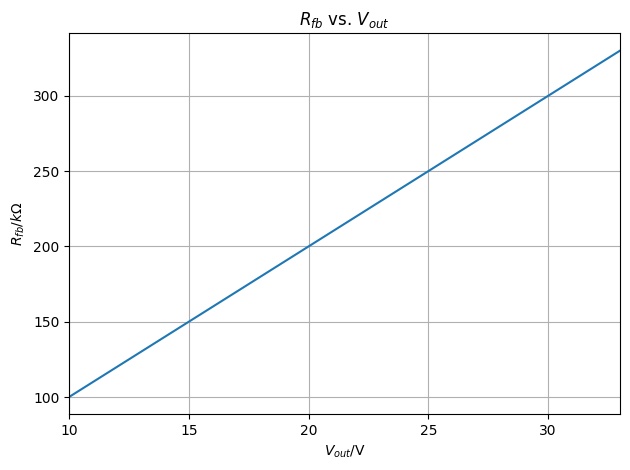

In [129]:
r_fb = n_ps_design * (v_out + v_f) / 100e-6

plt.plot(v_out, r_fb / 1e3)

plt.xlabel('$V_{out}$/V')
plt.ylabel('$R_{fb}/k\Omega$')
plt.title('$R_{fb}$ vs. $V_{out}$')
plt.xlim(10,33)
plt.grid(True)
plt.tight_layout()
plt.show()